# ERA5 QC and combine

In [1]:
import re
import os
import sys
import zarr
import yaml
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr

In [2]:
sys.path.insert(0, os.path.realpath('../libs/'))
import verif_utils as vu

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## QC

In [4]:
fn_6h = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/dscale/ERA5_dscale_GP_{}.zarr'
fn_1h_upper = '/glade/campaign/ral/hap/ksha/ERA5_data/upper_air/ERA5_plevel_1h_upper_air_{}.zarr'
fn_1h_surf = '/glade/campaign/ral/hap/ksha/ERA5_data/surf/ERA5_plevel_1h_surf_{}.zarr'

In [5]:
# year = 1990
# ds_6h = xr.open_zarr(fn_6h.format(year))
# ds_1h_upper = xr.open_zarr(fn_1h_upper.format(year))
# ds_1h_surf = xr.open_zarr(fn_1h_surf.format(year))

In [6]:
# fig_dir = '/glade/u/home/ksha/CONUS-404-prep/figures/'

In [7]:
# varnames = ['Q', 'T', 'U', 'V', 'Z']
# varname_surf = ['VAR_10U', 'VAR_10V', 'VAR_2T', 'MSL', 'SP']
# N_lev = 11

# for year in range(1986, 2023):
    
#     ds_6h = xr.open_zarr(fn_6h.format(year))
#     #ds_1h_upper = xr.open_zarr(fn_1h_upper.format(year))
#     ds_1h_surf = xr.open_zarr(fn_1h_surf.format(year))
    
#     t_6h = ds_6h['time']
#     t_1h = ds_1h_surf['time']
    
#     # for varname in varnames:
#     #     for ilev in range(N_lev):
#     #         var_6h_mean = ds_6h[varname].isel(level=ilev).mean(['south_north', 'west_east'])
#     #         var_1h_mean = ds_1h_upper[varname].isel(level=ilev).mean(['south_north', 'west_east'])
            
#     #         fig = plt.figure()
#     #         plt.plot(t_6h, var_6h_mean)
#     #         plt.plot(t_1h, var_1h_mean)
#     #         plt.title(f'{year} - {varname} - {ilev}', fontsize=14)
#     #         fig.savefig(fig_dir + f'{year}_{varname}_{ilev}.png', format='png')
            
#     for varname in varname_surf:
#         for ilev in range(N_lev):
#             var_6h_mean = ds_6h[varname].mean(['south_north', 'west_east'])
#             var_1h_mean = ds_1h_surf[varname].mean(['south_north', 'west_east'])
            
#             fig = plt.figure()
#             plt.plot(t_6h, var_6h_mean)
#             plt.plot(t_1h, var_1h_mean)
#             plt.title(f'{year} - {varname}', fontsize=14)
#             fig.savefig(fig_dir + f'{year}_{varname}.png', format='png')

```
(ERA5)
soil_temperature_level_1, 0-70cm
volumetric_soil_water_layer_1, 0-70cm

(GFS)
TSOIL:0-0.1 m below ground:anl:
SOILW:0-0.1 m below ground:anl:
```

### Gather prognostic outputs

In [8]:
fn_1h_upper = '/glade/campaign/ral/hap/ksha/ERA5_data/upper_air/ERA5_plevel_1h_upper_air_{}.zarr'
fn_1h_surf = '/glade/campaign/ral/hap/ksha/ERA5_data/surf/ERA5_plevel_1h_surf_{}.zarr'
fn_1h_land = '/glade/campaign/ral/hap/ksha/ERA5_data/land/ERA5_plevel_1h_land_{}.zarr'

static_WRF_name = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/static/C404_GP_static.zarr'
ds_WRF_static = xr.open_zarr(static_WRF_name)
LANDMASK = ds_WRF_static['LANDMASK'].values

In [9]:
year = 2024

In [10]:
varname_4d = ['U', 'V', 'Z', 'T', 'Q']

# Open input datasets
ds_1h_upper = xr.open_zarr(fn_1h_upper.format(year), chunks={})
ds_1h_surf = xr.open_zarr(fn_1h_surf.format(year), chunks={})
ds_1h_land = xr.open_zarr(fn_1h_land.format(year), chunks={})

# Merge datasets
ds_year = xr.merge([ds_1h_upper, ds_1h_surf, ds_1h_land])

# =================================================== #
# rechunk
ds_year = ds_year.chunk(
    {
        'time': 16, 
        'level': 11, 
        'south_north': 336, 
        'west_east': 336
    }
)

varnames = list(ds_year.keys())
# zarr encodings
dict_encoding = {}

chunk_size_3d = dict(chunks=(16, 336, 336))
chunk_size_4d = dict(chunks=(16, 15, 336, 336))

compress = zarr.Blosc(cname='zstd', clevel=1, shuffle=zarr.Blosc.SHUFFLE, blocksize=0)

for i_var, var in enumerate(varnames):
    if var in varname_4d:
        dict_encoding[var] = {'compressor': compress, **chunk_size_4d}
    else:
        dict_encoding[var] = {'compressor': compress, **chunk_size_3d}

save_name = f'/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/dscale_BCSD/ERA5_GP_1h_{year}.zarr'
# ds_year.to_zarr(save_name, mode='w', consolidated=True, compute=True, encoding=dict_encoding)

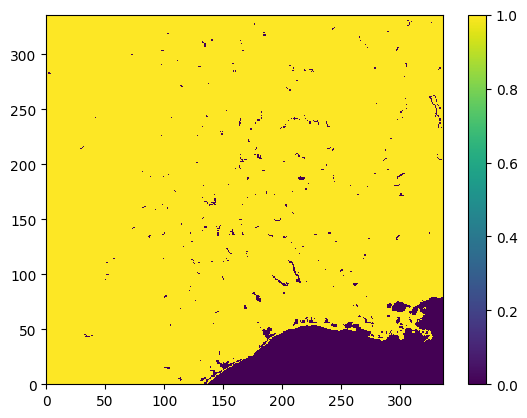

In [10]:
plt.pcolormesh(LANDMASK)
plt.colorbar()

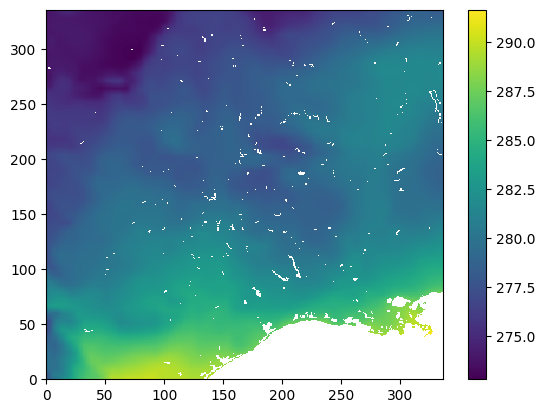

In [19]:
plt.pcolormesh(ds_year['soil_temperature_level_1'].isel(time=999).values)
plt.colorbar()

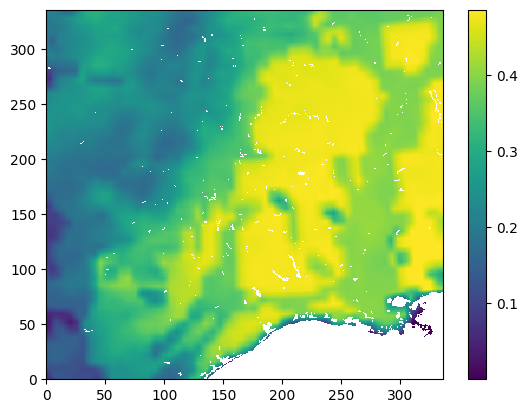

In [18]:
plt.pcolormesh(ds_year['volumetric_soil_water_layer_1'].isel(time=999).values)
plt.colorbar()

In [20]:
save_name = f'/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/dscale_1h/ERA5_GP_1h_{year}.zarr'
# ds_year.to_zarr(save_name, mode='w', consolidated=True, compute=True, encoding=dict_encoding)

In [21]:
ds_year = xr.open_zarr(save_name)

In [22]:
st = ds_year['soil_temperature_level_1'].isel(time=999).values

In [23]:
sm = ds_year['volumetric_soil_water_layer_1'].isel(time=999).values

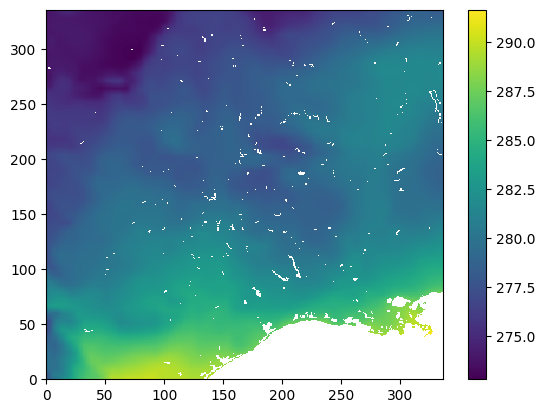

In [26]:
plt.pcolormesh(st)
plt.colorbar()

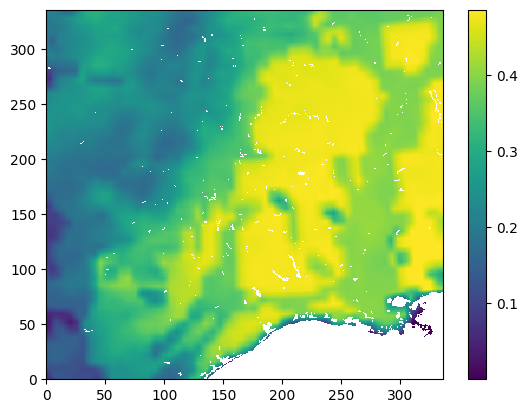

In [25]:
plt.pcolormesh(sm)
plt.colorbar()

In [5]:
import pygrib

In [1]:
fn = '/glade/u/home/ksha/CONUS-404-prep/gfs.t00z.pgrb2.0p25.f000'

In [6]:
grbs = pygrib.open(fn)

In [7]:
for grb in grbs:
    print(grb)

1:Pressure reduced to MSL:Pa (instant):regular_ll:meanSea:level 0:fcst time 0 hrs:from 202305150000
2:Cloud mixing ratio:kg kg**-1 (instant):regular_ll:hybrid:level 1:fcst time 0 hrs:from 202305150000
3:Ice water mixing ratio:kg kg**-1 (instant):regular_ll:hybrid:level 1:fcst time 0 hrs:from 202305150000
4:Rain mixing ratio:kg kg**-1 (instant):regular_ll:hybrid:level 1:fcst time 0 hrs:from 202305150000
5:Snow mixing ratio:kg kg**-1 (instant):regular_ll:hybrid:level 1:fcst time 0 hrs:from 202305150000
6:Graupel (snow pellets):kg kg**-1 (instant):regular_ll:hybrid:level 1:fcst time 0 hrs:from 202305150000
7:Derived radar reflectivity:dB (instant):regular_ll:hybrid:level 1:fcst time 0 hrs:from 202305150000
8:Derived radar reflectivity:dB (instant):regular_ll:hybrid:level 2:fcst time 0 hrs:from 202305150000
9:Maximum/Composite radar reflectivity:dB (instant):regular_ll:atmosphere:level 0 -:fcst time 0 hrs:from 202305150000
10:Visibility:m (instant):regular_ll:surface:level 0:fcst time 0 hr

In [10]:
TSOIL = grbs.select(name='Soil temperature')[0]

In [13]:
TSOIL_np = TSOIL.values

In [12]:
SOILW = grbs.select(name='Volumetric soil moisture content')[0]

In [14]:
SOILW_np = SOILW.values

In [15]:
TSOIL_np.shape

(721, 1440)

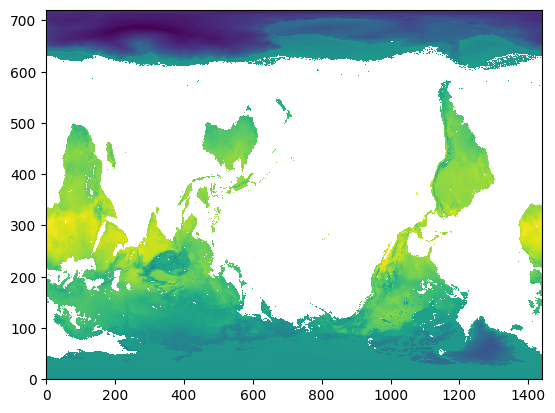

In [16]:
plt.pcolormesh(TSOIL_np)

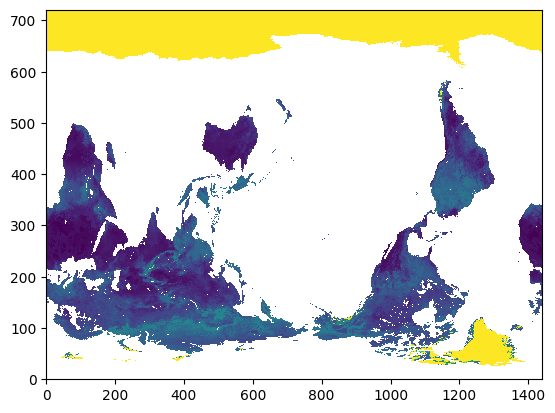

In [17]:
plt.pcolormesh(SOILW_np)

### Add 2021

In [3]:
fn_target = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/C404/C404_GP_2021.zarr'
ds_target = xr.open_zarr(fn_target)

In [6]:
ds_save = ds_target.isel(time=slice(120))

In [7]:
save_name = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/opt_init_ERA5/prog_outputs/opt_2021-01-01T00Z.zarr'

In [8]:
# ds_save.to_zarr(save_name, mode='w', consolidated=True, compute=True)

### To netCDF

In [6]:
ds_geo = xr.open_zarr('/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/static/C404_GP_static.zarr')
XLONG = ds_geo['XLONG'].values
XLAT = ds_geo['XLAT'].values

**Merge with diag**

In [7]:
# save_name = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/opt_init_ERA5/diag_outputs/diag_2020-01-01T00Z.zarr'
# ds_diag = xr.open_zarr(save_name)
# ds_diag = ds_diag.drop_vars(['forecast_hour'])

In [8]:
# ds_final = ds_final.isel(time=slice(1, None))
# ds_final = xr.merge([ds_final, ds_diag])
# ds_final['WRF_precip'] = ds_final['WRF_precip_025']**4
# ds_final['WRF_radar_composite'] = ds_final['WRF_radar_composite_025']**4
# ds_final = ds_final.drop_vars(['WRF_precip_025', 'WRF_radar_composite_025'])

**CF**

In [9]:
# Load dataset
save_name = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/opt_init_ERA5/prog_outputs/opt_2020-01-01T00Z.zarr'
ds_final = xr.open_zarr(save_name, chunks={})  # lazy load with Dask

# Square variables and drop originals
ds_final = ds_final.assign(
    WRF_PWAT=ds_final['WRF_PWAT_05'] ** 2,
    WRF_Q_tot=ds_final['WRF_Q_tot_05'] ** 2
).drop_vars(['WRF_PWAT_05', 'WRF_Q_tot_05'])

ds_final['WRF_precip'] = ds_final['WRF_precip_025']**4
ds_final['WRF_radar_composite'] = ds_final['WRF_radar_composite_025']**4
ds_final = ds_final.drop_vars(['WRF_precip_025', 'WRF_radar_composite_025'])

# Rename dimensions
ds_final = ds_final.rename({
    'bottom_top': 'level',
    'south_north': 'latitude',
    'west_east': 'longitude'
})

# Subset time
ds_final = ds_final.isel(time=slice(None, -1))

# Assign level coordinate
ds_final = ds_final.assign_coords(level=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 21, 24, 30, 36, 42])

# Drop old lat/lon and assign new ones
ds_final = ds_final.drop_vars(['latitude', 'longitude'], errors='ignore').assign_coords(
    XLAT=(('latitude', 'longitude'), XLAT),
    XLONG=(('latitude', 'longitude'), XLONG)
)

# Add global attribute
ds_final.attrs['Conventions'] = 'CF-1.11'

# Decode time
ds_final['time'] = xr.decode_cf(ds_final[['time']]).time

# Replace indexing dims with coordinate dims and standard names
if 'XLAT' in ds_final and 'XLONG' in ds_final:
    ds_final = ds_final.set_coords(['XLAT', 'XLONG'])
    ds_final['XLAT'] = ds_final['XLAT'].rename({'latitude': 'south_north', 'longitude': 'west_east'})
    ds_final['XLONG'] = ds_final['XLONG'].rename({'latitude': 'south_north', 'longitude': 'west_east'})

    ds_final['XLAT'].attrs.update({
        "standard_name": "latitude",
        "units": "degrees_north",
        "long_name": "latitude"
    })
    ds_final['XLONG'].attrs.update({
        "standard_name": "longitude",
        "units": "degrees_east",
        "long_name": "longitude"
    })

# Replace lat/lon dims with south_north/west_east
dim_map_3d = ('time', 'level', 'south_north', 'west_east')
dim_map_2d = ('time', 'south_north', 'west_east')

for var in ds_final.data_vars:
    dims = ds_final[var].dims
    dim_rename = {}
    if 'latitude' in dims:
        dim_rename['latitude'] = 'south_north'
    if 'longitude' in dims:
        dim_rename['longitude'] = 'west_east'
    
    if dim_rename:
        ds_final[var] = ds_final[var].rename(dim_rename)

In [10]:
ds_final

<xarray.Dataset>
Dimensions:              (time: 8783, south_north: 336, west_east: 336,
                          level: 15)
Coordinates:
  * level                (level) int64 0 2 4 6 8 10 12 14 16 18 21 24 30 36 42
  * time                 (time) datetime64[ns] 2020-01-01T01:00:00 ... 2020-1...
    XLAT                 (south_north, west_east) float32 27.87 27.87 ... 39.64
    XLONG                (south_north, west_east) float32 -102.5 ... -87.34
Dimensions without coordinates: south_north, west_east
Data variables: (12/21)
    WRF_GLW              (time, south_north, west_east) float32 dask.array<chunksize=(12, 336, 336), meta=np.ndarray>
    WRF_IVT_U            (time, south_north, west_east) float32 dask.array<chunksize=(12, 336, 336), meta=np.ndarray>
    WRF_IVT_V            (time, south_north, west_east) float32 dask.array<chunksize=(12, 336, 336), meta=np.ndarray>
    WRF_MSLP             (time, south_north, west_east) float32 dask.array<chunksize=(12, 336, 336), meta=np.ndarray>
    WRF_OLR              (time, south_north, west_east) float32 dask.array<chunksize=(12, 336, 336), meta=np.ndarray>
    WRF_P                (time, level, south_north, west_east) float32 dask.array<chunksize=(12, 15, 336, 336), meta=np.ndarray>
    ...                   ...
    WRF_V10              (time, south_north, west_east) float32 dask.array<chunksize=(12, 336, 336), meta=np.ndarray>
    forecast_hour        (time) int64 dask.array<chunksize=(12,), meta=np.ndarray>
    WRF_PWAT             (time, south_north, west_east) float32 dask.array<chunksize=(12, 336, 336), meta=np.ndarray>
    WRF_Q_tot            (time, level, south_north, west_east) float32 dask.array<chunksize=(12, 15, 336, 336), meta=np.ndarray>
    WRF_precip           (time, south_north, west_east) float32 dask.array<chunksize=(12, 336, 336), meta=np.ndarray>
    WRF_radar_composite  (time, south_north, west_east) float32 dask.array<chunksize=(12, 336, 336), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.11

In [11]:
output_name = '/glade/derecho/scratch/ksha/CONUS_GP_20250520_new/opt_2020010100Z_create_date_20250710.nc'
ds_final.to_netcdf(output_name, format='NETCDF4_CLASSIC')

In [12]:
xr.open_dataset('/glade/derecho/scratch/ksha/CONUS_GP_20250520_new/opt_2020010100Z_create_date_20250710.nc')

<xarray.Dataset>
Dimensions:              (time: 8783, south_north: 336, west_east: 336,
                          level: 15)
Coordinates:
  * level                (level) int32 0 2 4 6 8 10 12 14 16 18 21 24 30 36 42
  * time                 (time) datetime64[ns] 2020-01-01T01:00:00 ... 2020-1...
    XLAT                 (south_north, west_east) float32 ...
    XLONG                (south_north, west_east) float32 ...
Dimensions without coordinates: south_north, west_east
Data variables: (12/21)
    WRF_GLW              (time, south_north, west_east) float32 ...
    WRF_IVT_U            (time, south_north, west_east) float32 ...
    WRF_IVT_V            (time, south_north, west_east) float32 ...
    WRF_MSLP             (time, south_north, west_east) float32 ...
    WRF_OLR              (time, south_north, west_east) float32 ...
    WRF_P                (time, level, south_north, west_east) float32 ...
    ...                   ...
    WRF_V10              (time, south_north, west_east) float32 ...
    forecast_hour        (time) int32 ...
    WRF_PWAT             (time, south_north, west_east) float32 ...
    WRF_Q_tot            (time, level, south_north, west_east) float32 ...
    WRF_precip           (time, south_north, west_east) float32 ...
    WRF_radar_composite  (time, south_north, west_east) float32 ...
Attributes:
    Conventions:  CF-1.11

In [29]:
# save_name = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/opt_init_ERA5/prog_outputs/opt_2020-01-01T00Z.zarr'
# ds_final = xr.open_zarr(save_name)

# ds_final['WRF_PWAT'] = ds_final['WRF_PWAT_05']**2
# ds_final['WRF_Q_tot'] = ds_final['WRF_Q_tot_05']**2
# ds_final = ds_final.drop_vars(['WRF_PWAT_05', 'WRF_Q_tot_05'])
# ds_final = ds_final.rename({'bottom_top': 'level', 'south_north': 'latitude', 'west_east': 'longitude'})

# ds_final = ds_final.isel(time=slice(None, -1))
# ds_final['level'] = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 21, 24, 30, 36, 42]


# ds_final = ds_final.drop_vars(['longitude', 'latitude'])
# ds_final = ds_final.assign_coords(
#     XLAT=(('latitude', 'longitude'), XLAT),
#     XLONG=(('latitude', 'longitude'), XLONG)
# )

# ds_final.attrs['Conventions'] = 'CF-1.11'

# ds_final['time'] = xr.decode_cf(ds_final[['time']]).time

# # Replace indexing dims with coordinate dims
# if 'XLAT' in ds_final and 'XLONG' in ds_final:
#     ds_final = ds_final.set_coords(['XLAT', 'XLONG'])
#     ds_final['XLAT'] = ds_final['XLAT'].rename({'latitude': 'south_north', 'longitude': 'west_east'})
#     ds_final['XLONG'] = ds_final['XLONG'].rename({'latitude': 'south_north', 'longitude': 'west_east'})
    

# # Set CF-compliant attributes for lat/lon
# ds_final['XLAT'].attrs = {
#     "standard_name": "latitude",
#     "units": "degrees_north",
#     "long_name": "latitude"
# }
# ds_final['XLONG'].attrs = {
#     "standard_name": "longitude",
#     "units": "degrees_east",
#     "long_name": "longitude"
# }

# # Replace ('latitude', 'longitude') with ('south_north', 'west_east')
# for var in ds_final.data_vars:
#     dims = ds_final[var].dims
#     # 3D fields
#     if ('latitude' in dims or 'longitude' in dims) and 'level' in dims:
#         data = ds_final[var].data
#         ds_final = ds_final.drop_vars(var)
#         ds_final[var] = (('time', 'level', 'south_north', 'west_east'), data)
#     # 2D fields
#     elif 'latitude' in dims or 'longitude' in dims:
#         data = ds_final[var].data
#         ds_final = ds_final.drop_vars(var)
#         ds_final[var] = (('time', 'south_north', 'west_east'), data)

In [18]:
# time_encoding = {
#     "units": "hours since 1900-01-01 00:00:00",
#     "calendar": "gregorian"
# }

# ds_final.to_netcdf(
#     output_name,  
#     format='NETCDF4', 
#     encoding={'time': time_encoding}, 
#     mode='w'
# )

### To netCDF target

In [7]:
# Load dataset lazily
ds_C404 = xr.open_zarr('/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/C404/C404_GP_2020.zarr', chunks={})

# Drop unused variables
drop_vars = [
    'WRF_precip_025', 'WRF_radar_composite_025',
    'WRF_PWAT_05', 'WRF_Q_tot_05'
]
ds_C404 = ds_C404.drop_vars(drop_vars, errors='ignore')

# Rename dimensions
ds_C404 = ds_C404.rename({
    'bottom_top': 'level',
    'south_north': 'latitude',
    'west_east': 'longitude'
})

# Assign level coordinate
ds_C404 = ds_C404.assign_coords(level=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 21, 24, 30, 36, 42])

# Drop old lat/lon coords if present, then assign new ones
ds_C404 = ds_C404.drop_vars(['latitude', 'longitude'], errors='ignore').assign_coords(
    XLAT=(('latitude', 'longitude'), XLAT),
    XLONG=(('latitude', 'longitude'), XLONG)
)

# Set global attribute
ds_C404.attrs['Conventions'] = 'CF-1.11'

# Decode CF time
ds_C404['time'] = xr.decode_cf(ds_C404[['time']]).time

# Set coordinate variables and rename dims
if 'XLAT' in ds_C404 and 'XLONG' in ds_C404:
    ds_C404 = ds_C404.set_coords(['XLAT', 'XLONG'])

    # Rename only the coordinate dims, not data
    ds_C404['XLAT'] = ds_C404['XLAT'].rename({'latitude': 'south_north', 'longitude': 'west_east'})
    ds_C404['XLONG'] = ds_C404['XLONG'].rename({'latitude': 'south_north', 'longitude': 'west_east'})

    # Set CF metadata
    ds_C404['XLAT'].attrs.update({
        "standard_name": "latitude",
        "units": "degrees_north",
        "long_name": "latitude"
    })
    ds_C404['XLONG'].attrs.update({
        "standard_name": "longitude",
        "units": "degrees_east",
        "long_name": "longitude"
    })

# Rename lat/lon dims in data variables
for var in ds_C404.data_vars:
    dims = ds_C404[var].dims
    rename_dims = {}
    if 'latitude' in dims:
        rename_dims['latitude'] = 'south_north'
    if 'longitude' in dims:
        rename_dims['longitude'] = 'west_east'
    if rename_dims:
        ds_C404[var] = ds_C404[var].rename(rename_dims)

In [8]:
output_name = '/glade/derecho/scratch/ksha/CONUS_GP_20250520_new/target_2020010100Z_create_date_20250709.nc'
ds_C404.to_netcdf(output_name, format='NETCDF4_CLASSIC')

In [ ]:
/glade/derecho/scratch/ksha/CONUS_GP_20250520_new/opt_2020010100Z_create_date_20250709.nc
/glade/derecho/scratch/ksha/CONUS_GP_20250520_new/target_2020010100Z_create_date_20250709.nc

In [9]:
ds_C404

<xarray.Dataset>
Dimensions:              (time: 8784, south_north: 336, west_east: 336,
                          level: 15, pressure_approx: 15)
Coordinates:
  * level                (level) int64 0 2 4 6 8 10 12 14 16 18 21 24 30 36 42
  * pressure_approx      (pressure_approx) float32 1e+03 960.0 ... 180.0 100.0
  * time                 (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:0...
    XLAT                 (south_north, west_east) float32 27.87 27.87 ... 39.64
    XLONG                (south_north, west_east) float32 -102.5 ... -87.34
Dimensions without coordinates: south_north, west_east
Data variables: (12/21)
    WRF_GLW              (time, south_north, west_east) float32 dask.array<chunksize=(16, 336, 336), meta=np.ndarray>
    WRF_IVT_U            (time, south_north, west_east) float32 dask.array<chunksize=(16, 336, 336), meta=np.ndarray>
    WRF_IVT_V            (time, south_north, west_east) float32 dask.array<chunksize=(16, 336, 336), meta=np.ndarray>
    WRF_MSLP             (time, south_north, west_east) float32 dask.array<chunksize=(16, 336, 336), meta=np.ndarray>
    WRF_OLR              (time, south_north, west_east) float32 dask.array<chunksize=(16, 336, 336), meta=np.ndarray>
    WRF_P                (time, level, south_north, west_east) float32 dask.array<chunksize=(16, 15, 336, 336), meta=np.ndarray>
    ...                   ...
    WRF_U                (time, level, south_north, west_east) float32 dask.array<chunksize=(16, 15, 336, 336), meta=np.ndarray>
    WRF_U10              (time, south_north, west_east) float32 dask.array<chunksize=(16, 336, 336), meta=np.ndarray>
    WRF_V                (time, level, south_north, west_east) float32 dask.array<chunksize=(16, 15, 336, 336), meta=np.ndarray>
    WRF_V10              (time, south_north, west_east) float32 dask.array<chunksize=(16, 336, 336), meta=np.ndarray>
    WRF_precip           (time, south_north, west_east) float32 dask.array<chunksize=(16, 336, 336), meta=np.ndarray>
    WRF_radar_composite  (time, south_north, west_east) float32 dask.array<chunksize=(16, 336, 336), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.11

In [20]:
# ds_C404 = xr.open_zarr('/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/C404/C404_GP_2020.zarr')

# ds_C404 = ds_C404.drop_vars(
#     [
#         'WRF_precip_025', 'WRF_radar_composite_025', 
#         'WRF_PWAT_05', 'WRF_Q_tot_05'
#     ]
# )

# ds_C404 = ds_C404.rename({'bottom_top': 'level', 'south_north': 'latitude', 'west_east': 'longitude'})

# ds_C404['level'] = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 21, 24, 30, 36, 42]
# ds_C404 = ds_C404.drop_vars(['longitude', 'latitude'])
# ds_C404 = ds_C404.assign_coords(
#     XLAT=(('latitude', 'longitude'), XLAT),
#     XLONG=(('latitude', 'longitude'), XLONG)
# )
# ds_C404.attrs['Conventions'] = 'CF-1.11'

# ds_C404['time'] = xr.decode_cf(ds_C404[['time']]).time

# # Replace indexing dims with coordinate dims
# if 'XLAT' in ds_C404 and 'XLONG' in ds_C404:
#     ds_C404 = ds_C404.set_coords(['XLAT', 'XLONG'])
#     ds_C404['XLAT'] = ds_C404['XLAT'].rename({'latitude': 'south_north', 'longitude': 'west_east'})
#     ds_C404['XLONG'] = ds_C404['XLONG'].rename({'latitude': 'south_north', 'longitude': 'west_east'})
    

# # Set CF-compliant attributes for lat/lon
# ds_C404['XLAT'].attrs = {
#     "standard_name": "latitude",
#     "units": "degrees_north",
#     "long_name": "latitude"
# }
# ds_C404['XLONG'].attrs = {
#     "standard_name": "longitude",
#     "units": "degrees_east",
#     "long_name": "longitude"
# }

# # Replace ('latitude', 'longitude') with ('south_north', 'west_east')
# for var in ds_C404.data_vars:
#     dims = ds_C404[var].dims
#     # 3D fields
#     if ('latitude' in dims or 'longitude' in dims) and 'level' in dims:
#         data = ds_C404[var].data
#         ds_C404 = ds_C404.drop_vars(var)
#         ds_C404[var] = (('time', 'level', 'south_north', 'west_east'), data)
#     # 2D fields
#     elif 'latitude' in dims or 'longitude' in dims:
#         data = ds_C404[var].data
#         ds_C404 = ds_C404.drop_vars(var)
#         ds_C404[var] = (('time', 'south_north', 'west_east'), data)


In [ ]:
# target_name = '/glade/derecho/scratch/ksha/CONUS_GP_20250520_new/target_new_2020010100Z.nc'

# time_encoding = {
#     "units": "hours since 1900-01-01 00:00:00",
#     "calendar": "gregorian"
# }

# ds_C404.to_netcdf(
#     target_name,  
#     format='NETCDF4', 
#     encoding={'time': time_encoding}, 
#     mode='w'
# )